In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import pandas as pd
import csv
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from segment_anything import sam_model_registry, SamPredictor
from sklearn.model_selection import train_test_split

2025-05-07 12:24:19.241372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 12:24:19.998126: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asma/thermal-cnn/lib/python3.7/site-packages/cv2/../../lib64:
2025-05-07 12:24:19.998226: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asma/thermal-cnn/lib/python3.7/site-packages/cv2/../../l

In [2]:
# ----------------- CONFIGURATION -----------------
BASE_PATH = './data/resized_output'
FUSE_FOLDER = os.path.join(BASE_PATH, 'RMU/Fuse')
IMG_SIZE = (224, 224)
SAM_CHECKPOINT = "sam_vit_b_01ec64.pth"
DEVICE = "cpu"

In [3]:
# ----------------- COMPARTMENT LABELS -----------------
compartment_labels = {
    ("VCB", "CB Close Door"): 0,
    ("VCB", "CB Open door"): 1,
    ("VCB", "3 Core Cable"): 2,
    ("VCB", "1 core cable"): 3,
    ("VCB", "Cable"): 5,
    ("VCB", "Busbar top"): 6,
    ("VCB", "Busbar side"): 7,
    ("VCB", "PT"): 10,
    ("RMU", "Cable Entry"): 4,
    ("RMU", "Fuse"): 8,
    ("RMU", "Cable"): 5,
    ("RMU", "PT"): 10
}


In [4]:
# ----------------- DATA LOADING -----------------
# Load and label images
image_paths, labels = [], []
for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith('_resized.png'):
            full_path = os.path.join(root, file)
            folder_name = os.path.basename(root)
            parent_folder = os.path.basename(os.path.dirname(root))
            key = (parent_folder, folder_name)
            if key in compartment_labels:
                image_paths.append(full_path)
                labels.append(compartment_labels[key])

# Prepare data
X = []
for path in image_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, IMG_SIZE)
    X.append(img / 255.0)
X = np.array(X)
y = to_categorical(labels, num_classes=max(compartment_labels.values())+1)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# ----------------- MODEL TRAINING -----------------
# Build MobileNetV2 Model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(y.shape[1], activation='softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)])

2025-05-07 12:25:29.807803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-05-07 12:25:29.807833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tensorbook
2025-05-07 12:25:29.807841: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tensorbook
2025-05-07 12:25:29.807890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.183.1
2025-05-07 12:25:29.807916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.183.1
2025-05-07 12:25:29.807943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.183.1
2025-05-07 12:25:29.808333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Netw

Epoch 1/25


2025-05-07 12:25:31.157370: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 171601920 exceeds 10% of free system memory.


9/9 [==============================] - 6s 428ms/step - loss: 2.0596 - accuracy: 0.2982 - val_loss: 1.2271 - val_accuracy: 0.6389
Epoch 2/25
9/9 [==============================] - 3s 379ms/step - loss: 1.1113 - accuracy: 0.6456 - val_loss: 0.7913 - val_accuracy: 0.8194
Epoch 3/25
9/9 [==============================] - 3s 344ms/step - loss: 0.7217 - accuracy: 0.7825 - val_loss: 0.5973 - val_accuracy: 0.8333
Epoch 4/25
9/9 [==============================] - 3s 353ms/step - loss: 0.5179 - accuracy: 0.8561 - val_loss: 0.5223 - val_accuracy: 0.8333
Epoch 5/25
9/9 [==============================] - 3s 348ms/step - loss: 0.4100 - accuracy: 0.8561 - val_loss: 0.4679 - val_accuracy: 0.8472
Epoch 6/25
9/9 [==============================] - 3s 334ms/step - loss: 0.3096 - accuracy: 0.9053 - val_loss: 0.4459 - val_accuracy: 0.8889
Epoch 7/25
9/9 [==============================] - 3s 330ms/step - loss: 0.2788 - accuracy: 0.9228 - val_loss: 0.4374 - val_accuracy: 0.8611
Epoch 8/25
9/9 [===============

1/1 [==============================] - 0s 25ms/step


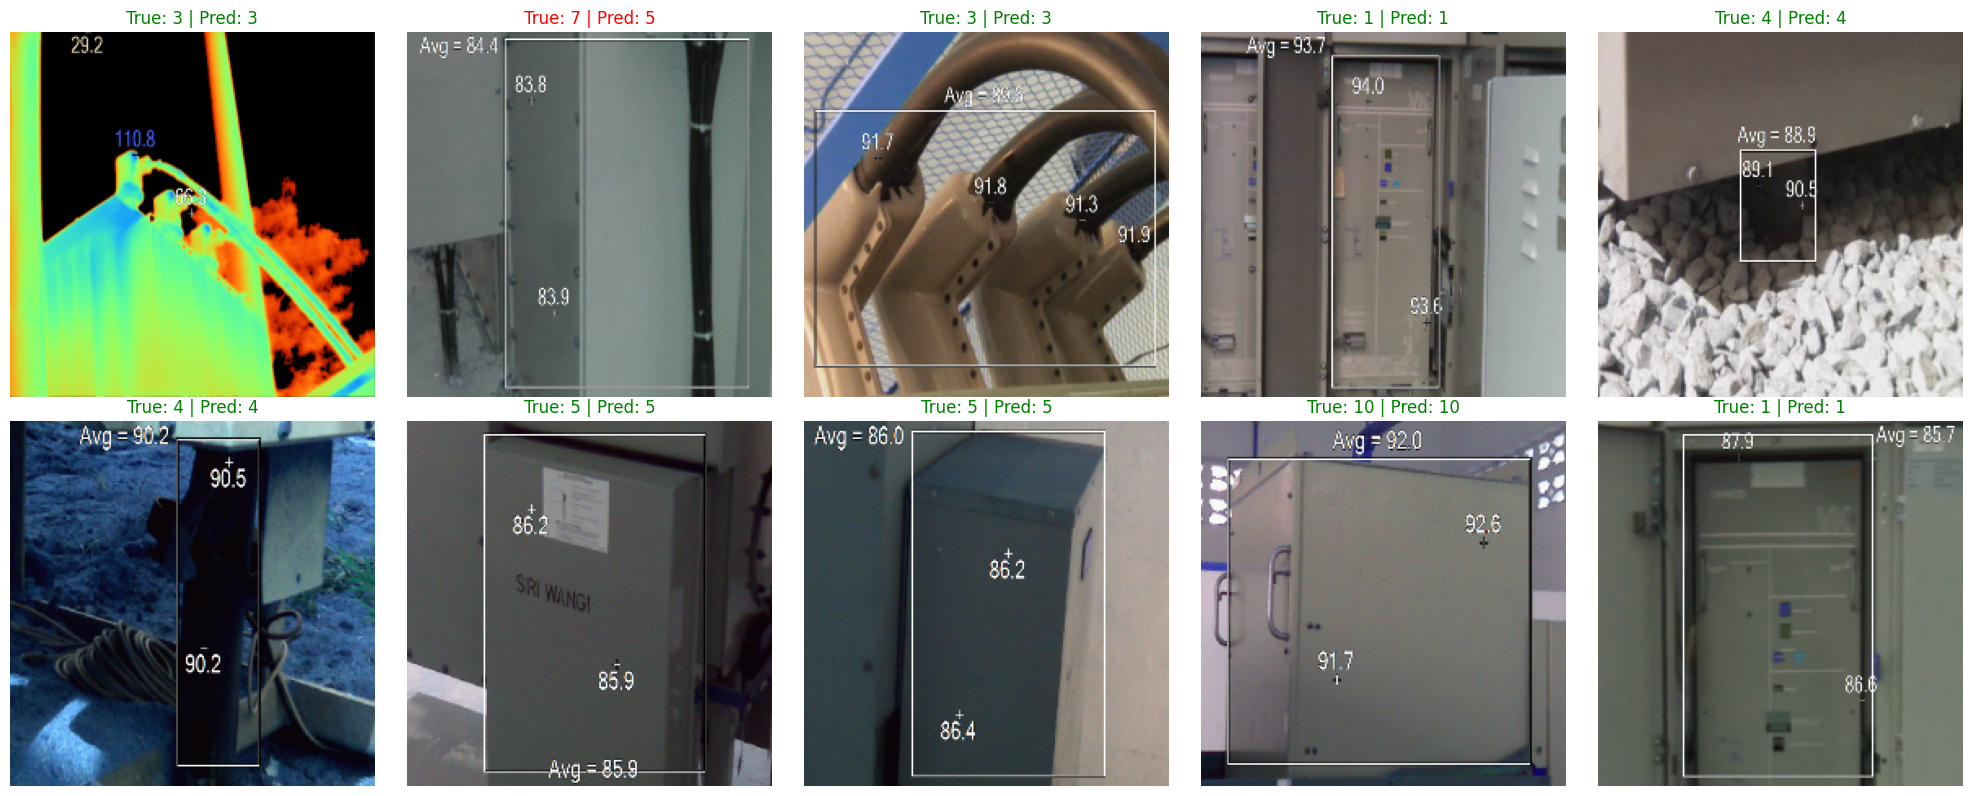

In [6]:
# ----------------- CLASSIFICATION CHECK (10 Samples) -----------------
sample_indices = random.sample(range(len(X_test)), 10)

plt.figure(figsize=(20, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    pred_label = np.argmax(model.predict(X_test[idx][np.newaxis]))
    true_label = np.argmax(y_test[idx])
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"True: {true_label} | Pred: {pred_label}", color=color, fontsize=12)
plt.tight_layout()
plt.show()

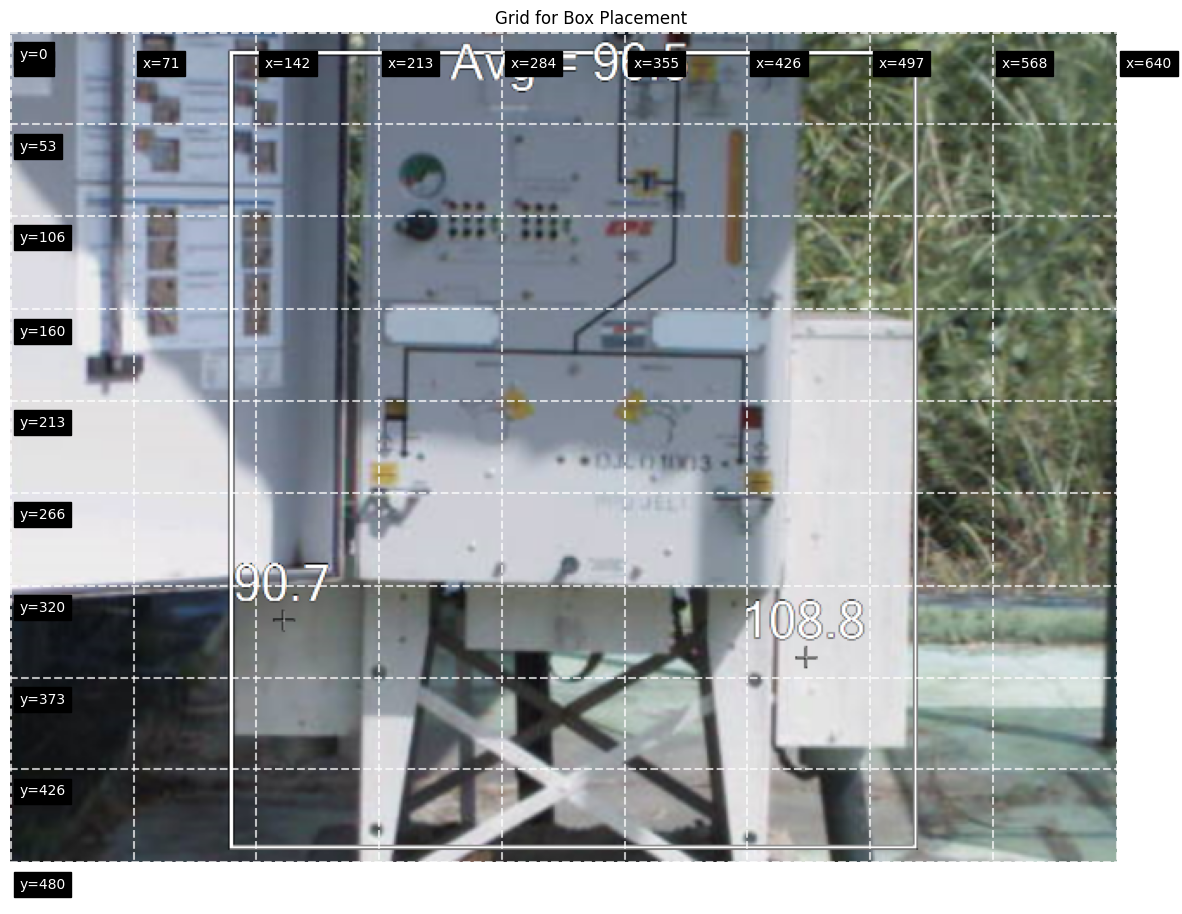

In [11]:
# ----------------- GRID FOR BOX PLACEMENT -----------------
fuse_image_path = random.choice([p for p in image_paths if '/Fuse/' in p])
img = cv2.imread(fuse_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 15))
plt.imshow(img_rgb)

# Add grid and labels
height, width, _ = img_rgb.shape
grid_x = np.linspace(0, width, 10, dtype=int)
grid_y = np.linspace(0, height, 10, dtype=int)

for x in grid_x:
    plt.axvline(x, color='white', linestyle='--', alpha=0.7)
    plt.text(x + 5, 20, f'x={x}', color='white', fontsize=10, backgroundcolor='black')

for y in grid_y:
    plt.axhline(y, color='white', linestyle='--', alpha=0.7)
    plt.text(5, y + 15, f'y={y}', color='white', fontsize=10, backgroundcolor='black')

plt.title("Grid for Box Placement")
plt.axis('off')
plt.show()

In [12]:
# ----------------- SAM SEGMENTATION -----------------
sam = sam_model_registry["vit_b"](checkpoint=SAM_CHECKPOINT).to(DEVICE)
predictor = SamPredictor(sam)
predictor.set_image(img_rgb)

input_box = np.array([[210, 0, 450, 300]])  # Adjust as needed
masks, scores, logits = predictor.predict(box=input_box, multimask_output=True)
best_mask = masks[np.argmax(scores)]

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# ----------------- THERMAL DATA LOADING -----------------
def load_smartview_csv(path):
    with open(path, 'r', encoding='utf-16', errors='ignore') as f:
        reader = csv.reader(f)
        rows = list(reader)

    thermal_matrix = []
    for row in rows:
        if row and row[0].strip().isdigit():
            try:
                thermal_matrix.append([float(val) for val in row[1:] if val.strip()])
            except ValueError:
                continue
    return np.array(thermal_matrix, dtype=np.float32)


thermal_csv_path = fuse_image_path.replace('_resized.png', '.csv').replace('resized_output', 'organized1')
thermal = load_smartview_csv(thermal_csv_path)

# ----------------- IMAGE RESIZING TO MATCH THERMAL -----------------
thermal_height, thermal_width = thermal.shape
resized_img_rgb = cv2.resize(img_rgb, (thermal_width, thermal_height), interpolation=cv2.INTER_LINEAR)

# ----------------- AUTO BOUNDING BOX + SEGMENTATION -----------------
x1, y1, x2, y2 = 100, 35, 200, 240
max_width = resized_img_rgb.shape[1]
valid_segment_found = False
attempts = 0
margin = 20

def is_valid_segment(mask, thermal_data):
    area = np.sum(mask)
    if area < 500:
        return False

    temps = thermal_data[mask]
    if len(temps[temps > 0]) == 0:
        return False

    delta = np.max(temps) - np.min(temps[temps > 0])
    if delta < 5:
        return False

    y_indices, x_indices = np.where(mask)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return False

    width = np.max(x_indices) - np.min(x_indices)
    height = np.max(y_indices) - np.min(y_indices)
    if height == 0 or width / height > 4 or height / width > 4:
        return False

    return True

while not valid_segment_found and attempts < 10:
    input_box = np.array([[x1, y1, x2, y2]])
    masks, scores, _ = predictor.predict(box=input_box, multimask_output=True)
    best_mask = masks[np.argmax(scores)]

    resized_best_mask = cv2.resize(best_mask.astype(np.uint8), (thermal_width, thermal_height), interpolation=cv2.INTER_NEAREST).astype(bool)
    if is_valid_segment(resized_best_mask, thermal):
        valid_segment_found = True
    else:
        x1 = max(0, x1 - margin)
        x2 = min(max_width, x2 + margin)
        attempts += 1

# ----------------- THERMAL MASKING -----------------
thermal_masked = np.zeros_like(thermal)
thermal_masked[resized_best_mask] = thermal[resized_best_mask]

# ----------------- VISUALIZATION -----------------
plt.figure(figsize=(18, 8))

# Full Image with Thermal Overlay
plt.subplot(1, 2, 1)
plt.imshow(resized_img_rgb)
plt.imshow(thermal, cmap='jet', alpha=0.4)
plt.title("Thermal Overlay - Full Image")
plt.axis('off')

# Isolated ROI
plt.subplot(1, 2, 2)
plt.imshow(resized_img_rgb)
plt.imshow(thermal_masked, cmap='jet', alpha=0.8)
plt.title("Thermal Overlay - Auto-Detected ROI")
plt.axis('off')

plt.show()

NameError: name 'fuse_image_path' is not defined

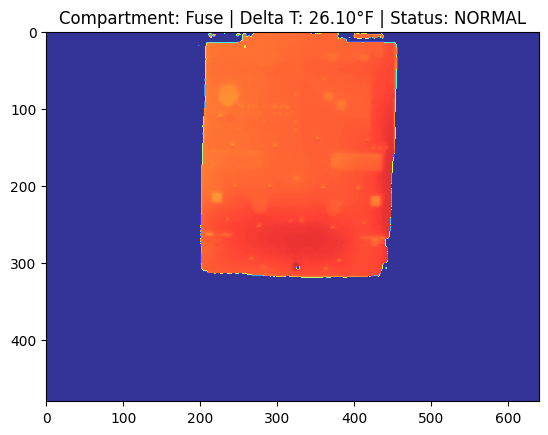

Max Temp: 112.50°F
Min Temp: 86.40°F
Delta T: 26.10°F
Status: NORMAL


In [15]:
# ----------------- DELTA T CALCULATION -----------------
max_temp = np.max(thermal_masked)
min_temp = np.min(thermal_masked[thermal_masked > 0])
delta_t = max_temp - min_temp
status = "DEFECT" if delta_t > 33.8 else "NORMAL"

plt.title(f"Compartment: Fuse | Delta T: {delta_t:.2f}°F | Status: {status}")
plt.imshow(thermal_masked, cmap='jet', alpha=0.8)
plt.show()

print(f"Max Temp: {max_temp:.2f}°F")
print(f"Min Temp: {min_temp:.2f}°F")
print(f"Delta T: {delta_t:.2f}°F")
print(f"Status: {status}")